Converged at iteration 1110


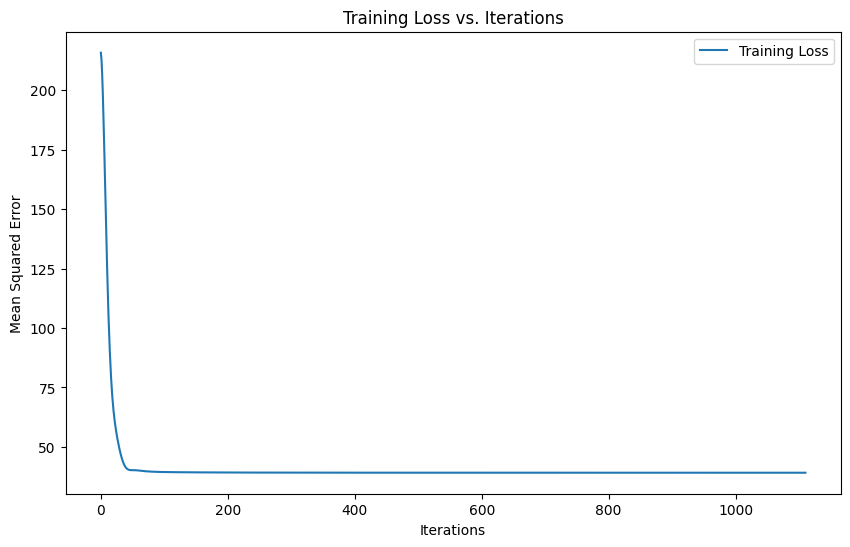

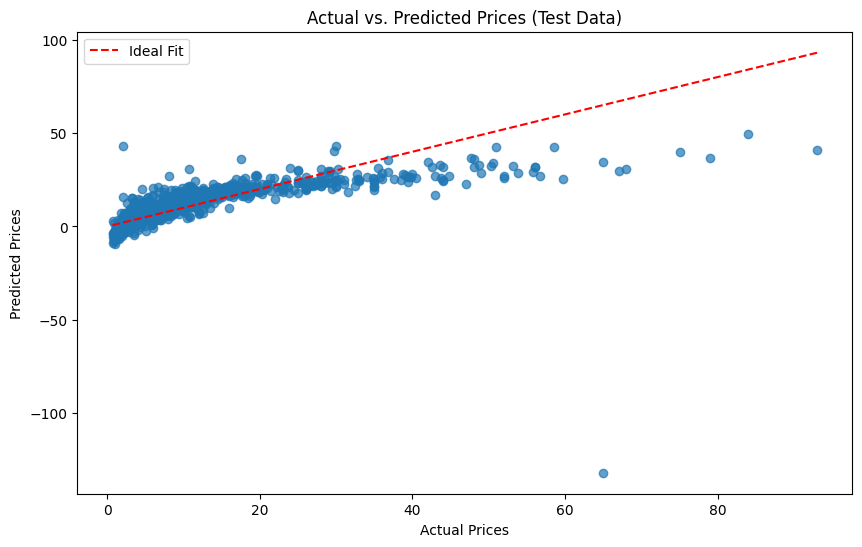

Mean Squared Error on Test Data (MSE): 67.42570064898356
Accuracy on Test Data: 45.62%


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

train_file_path = 'Train(1).csv'
test_file_path = 'Test.csv'

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

train_data = train_data.drop(['Unnamed: 0', 'Name'], axis=1)
test_data = test_data.drop(['Unnamed: 0', 'Name'], axis=1)

def extract_numeric(value):
    if isinstance(value, str):
        try:
            return float(value.replace(",", "").replace(" kmpl", "").replace(" CC", "").replace(" bhp", "").strip())
        except ValueError:
            return np.nan
    return value

train_data['Mileage'] = train_data['Mileage'].apply(extract_numeric)
train_data['Engine'] = train_data['Engine'].apply(extract_numeric)
train_data['Power'] = train_data['Power'].apply(extract_numeric)

test_data['Mileage'] = test_data['Mileage'].apply(extract_numeric)
test_data['Engine'] = test_data['Engine'].apply(extract_numeric)
test_data['Power'] = test_data['Power'].apply(extract_numeric)

train_data.fillna(train_data.median(numeric_only=True), inplace=True)
test_data.fillna(train_data.median(numeric_only=True), inplace=True)

train_data = pd.get_dummies(train_data, columns=['Location', 'Fuel_Type', 'Transmission', 'Owner_Type'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['Location', 'Fuel_Type', 'Transmission', 'Owner_Type'], drop_first=True)

X_train = train_data.drop('Price', axis=1)
y_train = train_data['Price']
X_test = test_data.drop('Price', axis=1)
y_test = test_data['Price']

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

weights = np.zeros(X_train_normalized.shape[1])
bias = 0
learning_rate = 0.005  # Reduced learning rate for finer updates
iterations = 5000  # Increased iterations for better convergence
lambda_reg = 0.05  # Reduced regularization strength to avoid underfitting
momentum = 0.9  # Added momentum for faster convergence
v_weights = np.zeros_like(weights)  # Velocity for weights
v_bias = 0  # Velocity for bias
costs = []

for i in range(iterations):
    y_pred = np.dot(X_train_normalized, weights) + bias
    error = y_pred - y_train
    dW = (1 / len(y_train)) * np.dot(X_train_normalized.T, error) + lambda_reg * weights
    db = (1 / len(y_train)) * np.sum(error)
    
    # Apply momentum
    v_weights = momentum * v_weights + learning_rate * dW
    v_bias = momentum * v_bias + learning_rate * db
    
    weights -= v_weights
    bias -= v_bias

    mse = np.mean(error ** 2) + (lambda_reg / 2) * np.sum(weights ** 2)
    costs.append(mse)
    if i > 0 and abs(costs[-2] - costs[-1]) < 1e-6:
        print(f"Converged at iteration {i}")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(len(costs)), costs, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.title('Training Loss vs. Iterations')
plt.legend()
plt.show()

y_test_pred = np.dot(X_test_normalized, weights) + bias
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices (Test Data)')
plt.legend()
plt.show()

mse_test = mean_squared_error(y_test, y_test_pred)
r2 = 1 - (np.sum((y_test - y_test_pred)**2) / np.sum((y_test - np.mean(y_test))**2))
accuracy = r2 * 100

print(f"Mean Squared Error on Test Data (MSE): {mse_test}")
print(f"Accuracy on Test Data: {accuracy:.2f}%")


# 